In [1]:
import os
import numpy as np
import lancet
import holoviews as hv

from featuremapper.analysis.raster import fft_power
from featuremapper.analysis.pinwheels import PinwheelAnalysis
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis
from topo.analysis.command import *
from analysis import *

import topo
from topo.analysis import Collector
from topo.submodel.gcal import ArraySpec

from topo.command import runscript  # In order to check the model files load correctly
from topo.misc.lancext import RunBatchCommand, topo_metadata

from components.lespi import ModelSEPI, ModelLESPI
hv.notebook_extension()

creating /var/folders/8w/1b1z92z13yq7_512bf4r7h5w0000gn/T/scipy-philippjfr-vYdkRW/python27_intermediate/compiler_3e90cc25296634f9584bdaec18683d04


## Experimental Setup

In [2]:
batch_name = 'SEPI_Spatial'

# Model options
laterals = False

# Measurements
rfs = True
isosuppression = True
sizetuning = True
frequencytuning = True
complexity = False
flankers = True

# Define times
times = [1000*i for i in range(21)]
print("Collection times start at %s and end at %s" % (min(times), max(times)))

# Define Args
constants = lancet.Args(area=4, laterals=laterals)
batch_arguments = constants * lancet.Args(times=times) * lancet.List('dataset', ['Gaussian', 'natural', 'treeshrew'])

Collection times start at 0 and end at 20000


## Define model

In [2]:
topo.sim.model = ModelSEPI(laterals=False, area=1.0, dependent_gaussians=True)
sepi = topo.sim.model.specification

In [4]:
sepi()

## Define Collector

In [4]:
c = Collector()

# Sheet activities
c.Activity.Retina =         c.collect(sepi.sheets.Retina)
c.Activity.V1Exc  =         c.collect(sepi.sheets.V1Exc)
c.Activity.V1PV   =         c.collect(sepi.sheets.V1PV)
# Connection fields
c.CFs.LGNOnAfferent =       c.collect(sepi.projections.V1Exc.LGNOnAfferent,  grid=True)
c.CFs.LGNOffAfferent =      c.collect(sepi.projections.V1Exc.LGNOffAfferent, grid=True)
c.CFs.PVLGNOnAfferent =       c.collect(sepi.projections.V1PV.LGNOnAfferent,  grid=True)
c.CFs.PVLGNOffAfferent =      c.collect(sepi.projections.V1PV.LGNOffAfferent, grid=True)
c.CFs.PV2Exc =   c.collect(sepi.projections.V1Exc.PVInhibition, grid=True)
c.CFs.Exc2PV =   c.collect(sepi.projections.V1PV.LateralPV, grid=True)
if laterals:
    c.CFS.LateralExcitatory = c.collect(sepi.projections.V1Exc.LateralExcitatory,
                                        grid=True, rows=47, cols=47,
                                        bounds=(-.5, -.5, .5, .5))

# OR preference measurement
c.collect(measure_or_pref)
# Sheet activities
c.Activity.Retina =         c.collect(sepi.sheets.Retina)
c.Activity.V1Exc =             c.collect(sepi.sheets.V1Exc)

# Homeostatic threshold
c.HomeostaticThreshold.V1Exc = c.collect(ArraySpec('V1Exc.output_fns[0].t'),
                                         group='Homeostatic Threshold')

# OR preference measurement
c.collect(measure_or_pref, frequencies=[1.4, 1.6])
c.collect(measure_response, durations=list(np.linspace(0,1,21)))
c.collect(measure_or_tuning_fullfield, contrasts=[5, 10, 30, 70, 100],
          frequencies=[1.4, 1.6], outputs=['V1Exc', 'V1PV'], times=[times[-1]])


if rfs:
    c.collect(measure_rfs, roi=(-.25, -.25, .25, .25), presentations=5000,
              scale=10, outputs=['V1Exc'], times=[times[-1]])
    
frequency=1.4

# Times and coords for further measurements
coords=[(0,-0.1),(-0.1,0.0),(0,0),(0,0.1),(0.1,0.0)]

# Analysis
c.Pinwheels.V1Exc =            c.analyze(c.ref.OrientationPreference.V1Exc[:, -1.5:1.5, -1.5:1.5]
                                         * c.ref.OrientationSelectivity.V1Exc[:, -1.5:1.5, -1.5:1.5], PinwheelAnalysis)
c.FFTAnalysis.V1Exc =          c.analyze(c.ref.OrientationPreference.V1Exc[:, -1.5:1.5, -1.5:1.5], PowerSpectrumAnalysis)

# Measure position preference, requisite for other measurements
if sizetuning or frequencytuning or flankers or complexity or isosuppression:
    c.collect(measure_position_pref, x_range=(-0.25,0.25), y_range=(-0.25,0.25),
              size=0.1, outputs=['V1Exc'], divisions=24, scale=2.0)

# Orientation Contrast Suppression
if isosuppression:
    c.analyze(c.ref.OrientationPreference.V1Exc, measure_iso_suppression, output='V1Exc',
              frequency=frequency, contrastcenter=70, contrastsurround=[10, 30, 70, 100],
              times=[times[-1]], mode='merge', num_orientation=11)
    
# Size Tuning Analysis
if sizetuning:
    c.analyze(c.ref.OrientationPreference.V1Exc, measure_size_tuning, num_phase=8, outputs=['V1Exc'],
              coords=coords, frequency=frequency, contrasts=[10, 100], times=[times[-1]], mode='merge')

# Frequency Tuning Analysis
if frequencytuning:
    c.collect(measure_frequency_response, num_phase=8, outputs=['V1Exc'], times=[times[-1]], max_freq=8)
    
# Measure PhaseTuning and Complexity
if complexity:
    c.analyze(c.ref.OrientationPreference.V1Exc, measure_phase_tuning, outputs=['V1Exc'], frequencies=[frequency],
              num_orientation=12, times=times, mode='merge')
    c.analyze(c.ref.PhaseTuning.V1Exc, ComplexityAnalysis, times=[times[-1]], mode='merge')

# Measure flanker modulation
if flankers:
    c.collect(measure_flanker_ormodulation, coords=coords, outputs=['V1Exc'], times=[times[-1]])
    c.collect(measure_flanker_xoffsetmodulation, coords=coords, outputs=['V1Exc'], times=[times[-1]])
    c.collect(measure_flanker_yoffsetmodulation, coords=coords, outputs=['V1Exc'], times=[times[-1]])

## Launcher

In [5]:
# Local or on cluster
QSUB = True
# Open diff in pager or not
SHOW_DIFF = True

ty_file = './sepi.ty'
metadata = topo_metadata()
output_directory = os.path.join(os.getcwd(), 'data')

lancet.review_and_launch.output_directory = output_directory

qsub_options = dict(b='y',
                    pe=('sharedmem', '6'),   # Parallel environment allocation
                    v='OMP_NUM_THREADS=6')   # Must match slot allocation above.

@lancet.review_and_launch()
def launch():
    runbatch_cmd = RunBatchCommand(ty_file, c, metadata=batch_arguments.varying_keys)
    Launcher = lancet.QLauncher if QSUB else lancet.Launcher
    return Launcher(batch_name, batch_arguments, runbatch_cmd,  metadata=metadata(), 
                    **({'qsub_flag_options':qsub_options} if QSUB else {}))
launch()


| Arguments Summary |

Items: 3
Varying Keys: 'dataset'
Constant Items: area=4, laterals=False, times=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]

Show available argument specifier entries? [y, N, quit]: 

| RunBatchCommand Summary |

Command executable: /exports/eddie/scratch/s1048519/topographica/topographica
Collector definition summary:

24 tasks scheduled:

  01.  Activity.Retina
           SheetSpec
  02.  Activity.V1Exc
           SheetSpec
  03.  Activity.V1PV
           SheetSpec
  04.  CFs.LGNOnAfferent
           ProjectionSpec [grid=True]
  05.  CFs.LGNOffAfferent
           ProjectionSpec [grid=True]
  06.  CFs.PVLGNOnAfferent
           ProjectionSpec [grid=True]
  07.  CFs.PVLGNOffAfferent
           ProjectionSpec [grid=True]
  08.  CFs.PV2Exc
           ProjectionSpec [grid=True]
  09.  CFs.Exc2PV
           ProjectionSpec [grid=True]
  10.  [...] 
          measure_or_pref
  11

Time: 000000.00 QLauncher: Invoked qsub for 3 commands


True

## Results

In [2]:
from holoviews.core.io import Unpickler
from analysis.progress import ProgressWidget, load_table
hv.notebook_extension('bokeh')

In [3]:
path = './data/2016-05-03_1326-SEPI_Spatial'
table = load_table(path)
data = Unpickler.collect(table, drop=['time', 'Index', 'tid', 'timestamps'])
ProgressWidget(path)

:Layout
   .DynamicMap.I   :DynamicMap   [Time]
   .DynamicMap.II  :DynamicMap   [Time]
   .DynamicMap.III :DynamicMap   [Time]
   .DynamicMap.IV  :DynamicMap   [Time]

In [5]:
from topo.command import load_snapshot
load_snapshot("./data/2016-05-03_1326-SEPI_Spatial/2016-05-03_1326_sepi_t0_dataset='Gaussian'/2016-05-03_1326_sepi_t0__020000.00.typ")

# Area summation estimates

In [5]:
%output backend='matplotlib' max_frames=10000 widgets='live'

In [6]:
from featuremapper.analysis.spatialtuning import Size_DivDoGModel, Size_iDoGModel, SizeTuningPeaks

In [6]:
size_response = data.SizeResponse.V1Exc()
orpref = data.OrientationPreference.V1Exc.select(time=20000)()
grouped_responses = size_response.groupby(['X', 'Y'])
fitted_curves = hv.HoloMap(kdims=['X', 'Y', 'Dataset', 'Contrast', 'x', 'y'])
for (X, Y), hmap in grouped_responses.items():
    curves = hmap.reindex().sample((10, 10), bounds=(X-.1, Y-.1, X+.1, Y+.1)).to.curve('Size', 'Response')
    for (ds, contrast, x, y), curve in curves.items():
        measured_or = orpref.select(dataset=ds).last[X, Y]
        cell_or = orpref.select(dataset=ds).last[x, y]
        if circular_dist(measured_or, cell_or, np.pi) < np.pi/16.:
            fitted_curves[X, Y, ds, contrast, x, y] = Size_iDoGModel(curve)
v1_dog_fits = fitted_curves.collate()

In [7]:
v1_dog_table = v1_dog_fits.ItemTable.IDoG_Model_Fit.table()
df = v1_dog_table.dframe()
good_fits = df[(df['$r^2$']>0.8)]# & (df.Dataset=='Gaussian')]
grouped_fits = good_fits.groupby(['X', 'Y', 'Dataset', 'x', 'y'])

def filter_fn(x):
    contrasts = list(x.Contrast)
    return 10 in contrasts and 70 in contrasts

good_fit_table = v1_dog_table.clone(grouped_fits.filter(filter_fn))

In [8]:
def logx(plot, element):
    ax = plot.handles['axis']
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params('both', length=4, width=0.5, which='minor')
    ax.tick_params('both', length=8, width=0.5, which='major')
    ax.xaxis.set_ticks([0.01, 0.1, 1, 10])
    ax.xaxis.set_ticklabels([0.01, 0.1, 1, 10])
    ax.yaxis.set_ticks([0.01, 0.1, 1, 10])
    ax.yaxis.set_ticklabels([0.01, 0.1, 1, 10])
    ax.set_aspect(1)
    ax.set_ylim([0.1, 10])
    ax.set_xlim([0.1, 10])

In [9]:
%%output fig='svg' filename='SEPI_V1_DoG_Contrast'
%%opts Path [fontsize=dict(labels=20)] (color='k' linestyle='--' linewidth=0.8)
%%opts Overlay [bgcolor='w' show_frame=False] Points (color='none' edgecolor='k' s=25) []
%%opts Histogram (facecolor='w' edgecolor='k') [yaxis=None fontsize=dict(labels=20)] 
%%opts VLine (color='k' linewidth=2 linestyle='--') Overlay [bgcolor='w' show_frame=False]
low = good_fit_table.select(Contrast=10).data.copy()
high = good_fit_table.select(Contrast=70).data.copy()
css_table = hv.Table([(k, v['a'].iloc[0]/v['a'].iloc[1]) for k, v in grouped_fits if len(v) > 1],
                     kdims=['X', 'Y', 'Dataset', 'x', 'y'], vdims=['$a_{low}/a_{high}$'])

((hv.Path([[(0,0), (10, 10)]], kdims=['$a_{low}$', '$a_{high}$']) *\
hv.Points((high.a, low.a)))(plot=dict(final_hooks=[logx])) +\
css_table.hist('$a_{low}/a_{high}$', adjoin=False, bin_range=(0, 5), num_bins=11) *\
hv.Text(3.5, 0.4, '$\overline{CSS} = %.4g$' % css_table['$a_{low}/a_{high}$'].mean()) *\
hv.VLine(1)).cols(2)

:Layout
   .Overlay.I  :Overlay
      .Path.I   :Path   [$a_{low}$,$a_{high}$]
      .Points.I :Points   [x,y]
   .Overlay.II :Overlay
      .Histogram.I :Histogram   [$a_{low}/a_{high}$]   (Frequency)
      .Text.I      :Text   [x,y]
      .VLine.I     :VLine   [x,y]

#### Figure 5.6:

Contrast-dependent shifts in size tuning as estimated by the DoG model. A) Spatial constant of the excitatory center of the DoG model at low vs. high contrast. B) Distribution of contrast-dependent shifts, showing a much better match to the experimental data than GCAL or SCAL (see figure 4.12).

:Layout
   .BoxWhisker.I  :BoxWhisker   [Contrast]   (a)
   .BoxWhisker.II :BoxWhisker   [Contrast]   (b)
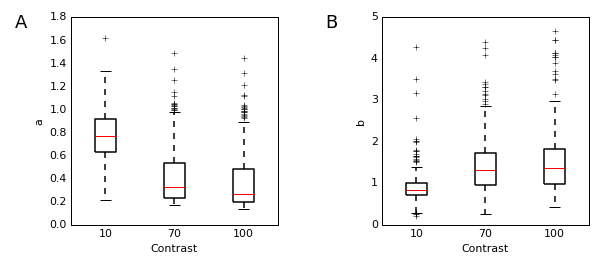

In [10]:
%%opts BoxWhisker [bgcolor='w']
good_fit_table.select(a=(0, 5), b=(0, 5)).to.box(['Contrast'], 'a', []) +\
good_fit_table.select(a=(0, 5), b=(0, 5)).to.box(['Contrast'], 'b', [])

In [11]:
%%output size=150 dpi=300 fig='svg' filename='V1_DoG_Distribution'
%%opts Histogram (edgecolor='k' facecolor='white') [fontsize={'xlabel':15, 'ticks':14}] {+axiswise}
%%opts Overlay [yaxis=None show_frame=False aspect=2 bgcolor='none' title_format='']
%%opts Layout [sublabel_position=(-0.15, 0.85) aspect_weight=1 sublabel_format='' hspace=0.3 vspace=0.4]

df = good_fit_table.select(Contrast=70).dframe()
df['a'] *= 3
df['b'] *= 3

peak_mean = df['a'].mean()
peak_median = df['a'].median()
surr_mean = df['b'].mean()
surr_median = df['b'].median()
peak_arrow = hv.Arrow(peak_median, 0, '', 'v')
surr_arrow = hv.Arrow(surr_median, 0, '', 'v')

size_tuning = (((hv.Table(df).hist(dimension='a', adjoin=False, num_bins=11)\
 .clone(kdims=[hv.Dimension('$r_c$', unit='$mm$')]) * peak_arrow).relabel('Size tuning center') *\
hv.Text(3, 0.5, '$n = %s$' % len(df), fontsize=16))(plot=dict(xticks=range(7))) +\
(hv.Table(df).hist(dimension='b', bin_range=(0, 10), adjoin=False, num_bins=11)\
 .clone(kdims=[hv.Dimension('$r_s$', unit='$mm$')]) * surr_arrow).relabel('Size tuning surround'))
size_tuning.cols(1)

:Layout
   .Overlay.I                    :Overlay
      .Histogram.I :Histogram   [$r_c$]   (Frequency)
      .Arrow.I     :Arrow   [x,y]
      .Text.I      :Text   [x,y]
   .Overlay.Size_tuning_surround :Overlay
      .Histogram.I :Histogram   [$r_s$]   (Frequency)
      .Arrow.I     :Arrow   [x,y]

#### Figure 5.7:

Spatial distribution of weights targeting A) iso-orientation regions, B) oblique-orientation regions and C) cross-orientation regions. Inhibitory neurons in the SEPI model have a much broader distribution of connections in the orientation domain, more closely matching Kisvárday et al. (1997) than the SCAL model.

## Suppression Index

In [12]:
%%output dpi=120 size=120 fig='svg' filename='SCAL_V1_SI'
%%opts Overlay [aspect=1.5 show_frame=False bgcolor='none']
%%opts Histogram (edgecolor='k' facecolor='white') [fontsize={'xlabel':15, 'ticks':14} yaxis=None ]
import scipy.stats as ss
df = df[df.SI<1]
df = df[df.Contrast==70]
si_dist = (good_fit_table.select(Contrast=70).hist(dimension='SI', bin_range=(0, 1), adjoin=False).clone(extents=(0, None, 1.01, None), group='Suppression Index') *
           hv.Text(0.25, 2.5, '$\overline{SI}$: $%.3f \pm %.3f$' % (df.SI.mean(), ss.sem(df.SI)), fontsize=10))
si_dist

:Overlay
   .Suppression_Index.I :Histogram   [SI]   (Frequency)
   .Text.I              :Text   [x,y]

# Orientation Tuning properties

In [7]:
hv.notebook_extension('matplotlib')

:GridSpace   [x,y]
   :HoloMap   [dataset,Time,Duration]
      :NdOverlay   [Contrast]
         :Curve   [Orientation]   (Response)
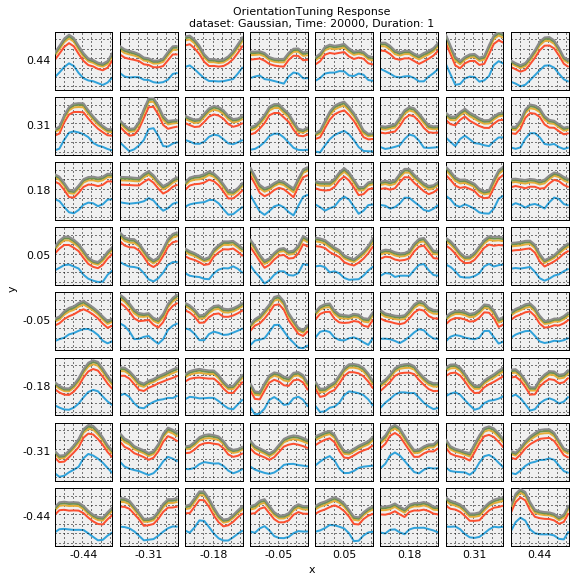
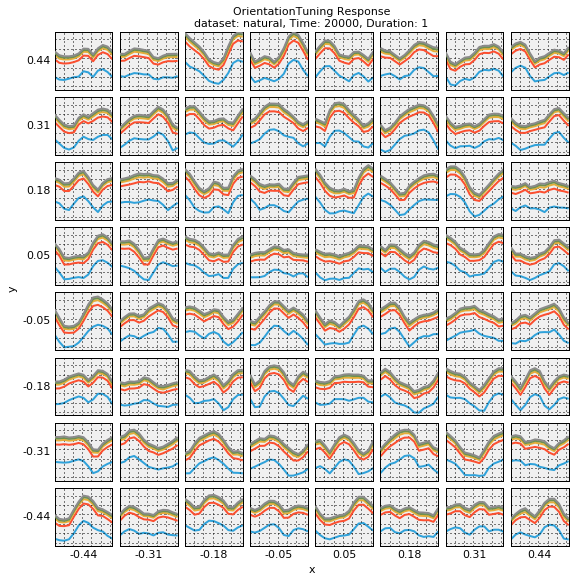
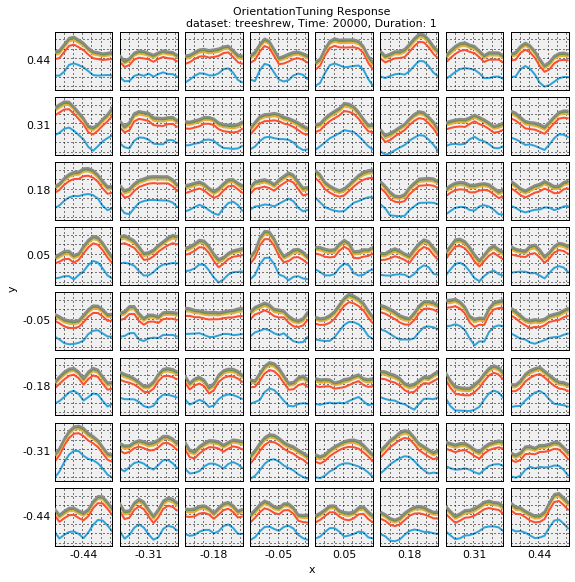

In [8]:
%%output size=150
ortuning = data.OrientationTuning.V1PV()
ortuning_samples = ortuning.sample((8, 8), bounds=(-.5, -.5, .5, .5))
pv_tuning_grid = ortuning_samples.to.curve('Orientation', 'Response').overlay('Contrast').grid(['x', 'y'])
pv_tuning_grid

:GridSpace   [x,y]
   :HoloMap   [dataset,Time,Duration]
      :NdOverlay   [Contrast]
         :Curve   [Orientation]   (Response)
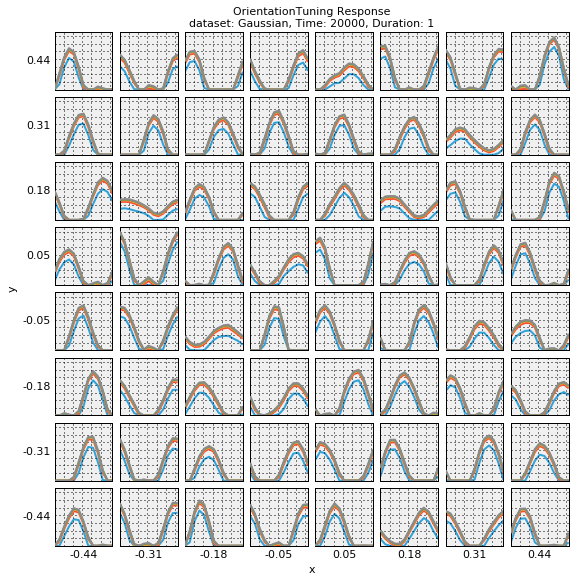
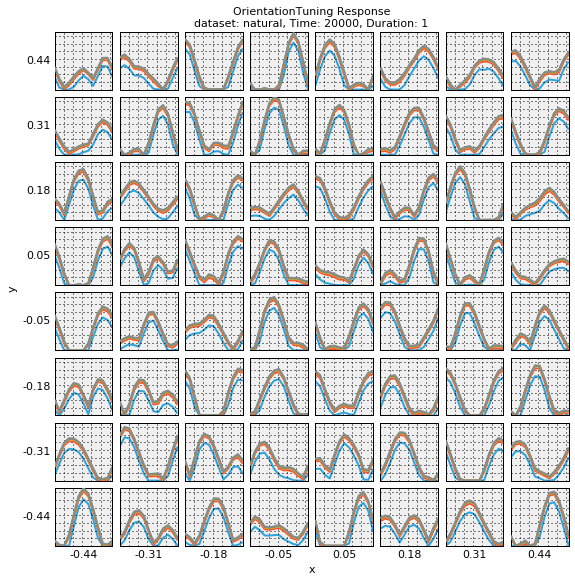
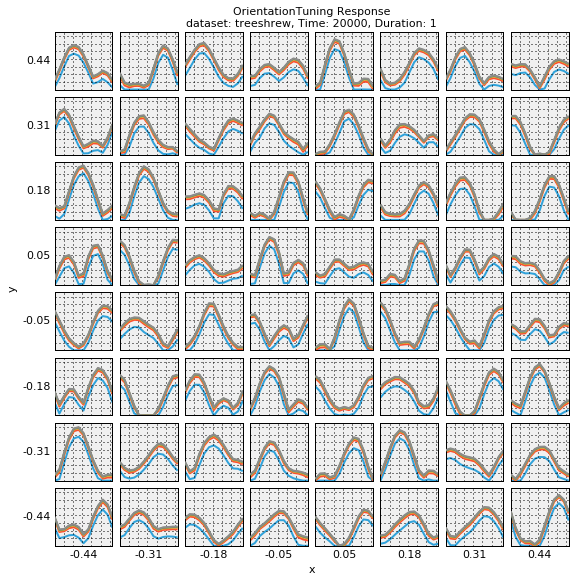

In [9]:
%%output size=150
ortuning = data.OrientationTuning.V1Exc()
ortuning_samples = ortuning.sample((8, 8), bounds=(-.5, -.5, .5, .5))
tuning_grid = ortuning_samples.to.curve('Orientation', 'Response').overlay('Contrast').grid(['x', 'y'])
tuning_grid

In [12]:
tuning_width_exc = TuningWidth(tuning_grid.select(dataset='Gaussian'))
collated  = hv.Collator(tuning_width_exc, kdims=tuning_width_exc.kdims)().collate(hv.HoloMap)
tuning_table = hv.Table(collated.Table.I.table().data.reset_index(drop=True))

In [13]:
import analysis

In [14]:
orpref = data.OrientationPreference.V1Exc.select(time=20000)()
lhi = LocalHomogeneityIndex(orpref['Gaussian'].last)
lhi_df = lhi.dframe()
lhi_df.x = lhi_df.x.round(6)
lhi_df.y = lhi_df.y.round(6)
bw_df = tuning_table.dframe()
bw_df.x = bw_df.x.round(6)
bw_df.y = bw_df.y.round(6)

In [15]:
%%output fig='svg' filename='SEPI_LHI' dpi=120
%%opts Overlay [bgcolor='none' show_frame=False] Points (color='grey' alpha=0.3 s=30)
lhi_table = hv.Table(lhi_df.merge(bw_df, on=['x', 'y']))
hv.RGB.load_image('./Nauhaus_LHI.png', bounds=(0, 0, 1, 60), kdims=['LHI', 'Tuning Width ($\degree$)']) *\
lhi_table.to.points(['LHI', 'Bandwidth'], [], []) * hv.Points([(0.69, 62.5)]) * hv.Text(0.78, 62.4, 'SEPI', fontsize=10)

:Overlay
   .RGB.I     :RGB   [LHI,Tuning Width ($\degree$)]   (R,G,B,A)
   .Points.I  :Points   [LHI,Bandwidth]
   .Points.II :Points   [x,y]
   .Text.I    :Text   [x,y]

#### Figure 5.8: 

Local homogeneity index against tuning width in the SEPI model compared to experimental results from macaque monkey and cat. Reproduced from Nauhaus et al. (2008). Provides another confirmation of appropriate spatial calibration, as the LHI is dependent on the scale of orientation columns.

In [16]:
tuning_width_pv = TuningWidth(pv_tuning_grid.select(dataset='Gaussian'))
collated  = hv.Collator(tuning_width_pv, kdims=tuning_width_pv.kdims)().collate(hv.HoloMap)
pv_tuning_table = hv.Table(collated.Table.I.table().data.reset_index(drop=True))

In [17]:
pv_bw_df = pv_tuning_table.dframe()
pv_bw_df.x = pv_bw_df.x.round(6)
pv_bw_df.y = pv_bw_df.y.round(6)

In [18]:
from featuremapper.analysis import center_cyclic
tuning_overlay = tuning_grid[0, 0].select(dataset='Gaussian').last.map(center_cyclic, [hv.Curve])
pv_tuning_overlay = pv_tuning_grid[0.44, 0.44].select(dataset='Gaussian').last.map(center_cyclic, [hv.Curve])

normalized_tuning = tuning_overlay.clone(shared_data=False)
for key, curve in tuning_overlay.items():
    curve_data = curve.columns()
    max_r = curve.range('Response')[1]
    max_r = max_r if max_r else 1
    curve_data['Normalized Response'] = curve_data['Response']/max_r
    normalized_tuning[key] = curve.clone(curve_data, vdims=['Normalized Response'])
    
pv_normalized_tuning = tuning_overlay.clone(shared_data=False)
for key, curve in pv_tuning_overlay.items():
    curve_data = curve.columns()
    max_r = curve.range('Response')[1]
    max_r = max_r if max_r else 1
    curve_data['Normalized Response'] = curve_data['Response']/max_r
    pv_normalized_tuning[key] = curve.clone(curve_data, vdims=['Normalized Response'])

In [19]:
def subtract_mean(rf):
    return rf.clone(rf.data-rf.data.mean())

In [24]:
%%output fig='svg' filename='SEPI_V1_ORTuning'
%%opts NdOverlay [aspect=1 xaxis='bottom' bgcolor='none' show_frame=False legend_position='right' xticks=list(np.linspace(-np.pi/2, np.pi/2., 5))]
%%opts Curve (color=hv.core.options.Palette('gray', reverse=True)[:0.8])
%%opts Points (edgecolor='k' color='none' linewidth=1)
%%opts Image.Receptive_Field (cmap='RdBu_r') [symmetric=False]
selection = dict(time=20000, dataset='Gaussian')
orpref = data.OrientationPreference.V1Exc.select(**selection)()
orsel = data.OrientationSelectivity.V1Exc.select(**selection)()
rfs = data.Retina_Reverse_Correlation.V1Exc.select(**selection)()
rf_slice = rfs.clone({(x, y): rf.last[x-1.25:x+1.25, y-1.25: y+1.25] for (x, y), rf in rffit.RFGaborFit.RF_Fit[-.5:.5:4, -.5:.5:4].items()})
(orpref.last[-1:1, -1:1] * hv.Points(rf_slice.keys()) + rf_slice.map(subtract_mean, [hv.Image]) + normalized_tuning(plot=dict(show_legend=False)) + pv_tuning_overlay).cols(2)

:Layout
   .Overlay.I                     :Overlay
      .Orientation_Preference.V1Exc :Image   [x,y]   (Orientation Preference)
      .Points.I                     :Points   [x,y]
   .RFs.V1Exc                     :GridSpace   [X,Y]
      :Image   [x,y]   (Weight)
   .OrientationTuning_Response.I  :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Normalized Response)
   .OrientationTuning_Response.II :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Response)

#### Figure 5.5:

SEPI model orientation tuning properties after presenting 20,000 oriented Gaussian patterns. A) Orientation map measured by presenting sine gratings at the optimal spatial frequency to the model, along with the locations of the receptive fields shown in B. B) Gabor-fits to receptive fields measured using sparse random noise. C) Orientation tuning curve of a single excitatory neuron across contrasts, demonstrating largely contrast-independent orientation tuning. D) Orientation tuning curve of a PV neuron displaying a weakly tuned response, with a certain baseline of activity which is only weakly modulated by orientation.

In [32]:
%%output fig='svg' filename='SCAL_ORTuning'
%%opts Layout [sublabel_position=(-0.25, 0.85) hspace=0.25]
%%opts NdOverlay [aspect=1.5 xaxis='bottom' bgcolor='none' show_frame=False legend_position='right']
%%opts Curve (color=hv.core.options.Palette('gray', reverse=True)[:0.8])
tuning_overlay(plot=dict(show_legend=False)) + normalized_tuning

:Layout
   .OrientationTuning_Response.I  :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Response)
   .OrientationTuning_Response.II :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Normalized Response)

# Inhibitory Weight Distributions

In [24]:
from topo.analysis import weights as weight_analysis
reload(weight_analysis)

<module 'topo.analysis.weights' from '/Users/philippjfr/topographica/topo/analysis/weights.pyc'>

:Layout
   .Orientation_Weight_Distribution.V1Exc_LateralInhibitory :Histogram   [Orientation Difference]   (Weight)
   .Weight_Isotropy.V1Exc_LateralInhibitory                 :Histogram   [Azimuth]   (Frequency)
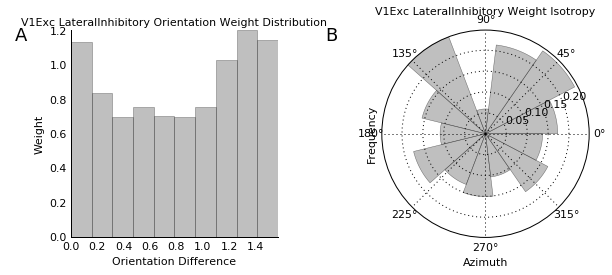

In [25]:
%%opts Histogram [bgcolor='none'] (facecolor='grey' alpha=0.5)

from topo.analysis.weights import WeightDistribution, WeightIsotropy

latinh = data.CFs.PV2Exc.select(time=20000)()
orpref = data.OrientationPreference.V1Exc.select(time=20000)()
xpref = data.XPreference.V1Exc.select(time=20000)()
ypref = data.YPreference.V1Exc.select(time=20000)()

tree = hv.Layout()
tree.OrientationPreference.V1Exc = orpref.last
tree.XPreference.V1Exc = xpref.select(dataset='Gaussian').last
tree.YPreference.V1Exc = ypref.select(dataset='Gaussian').last
tree.CFs.LateralInhibitory = latinh.select(dataset='Gaussian', X=(-.5, .5), Y=(-.5, .5))

weight_orientation = weight_analysis.WeightDistribution(tree, projections=[('V1Exc', 'LateralInhibitory')])
weight_isotropy = weight_analysis.WeightIsotropy(tree, projections=[('V1Exc', 'LateralInhibitory')], num_bins=13)
weight_orientation.WeightDistribution.V1Exc_LateralInhibitory.reindex(['dataset']).select(dataset='Gaussian')+\
weight_isotropy.WeightIsotropy.V1Exc_LateralInhibitory.reindex(['dataset']).select(dataset='Gaussian')(plot=dict(projection='polar'))

In [27]:
%%output fig='svg' filename='SEPI_Inh_OR_Distributions'
%%opts Histogram [aspect=1.5 bgcolor='none'] (edgecolor='k' facecolor='w') {-axiswise}
cross = weight_orientation.WeightDistribution.Cross_V1Exc_LateralInhibitory.last
iso = weight_orientation.WeightDistribution.Iso_V1Exc_LateralInhibitory.last
oblique = weight_orientation.WeightDistribution.Oblique_V1Exc_LateralInhibitory.last
(iso + oblique + cross).map(lambda x: x.clone((x.data[0], x.data[1]*3000), kdims=[hv.Dimension('Distance', unit='$\mu m$')],
                                              extents=None, label=''), [hv.Histogram])

:Layout
   .Iso_hyphen_minus_Orientation_Weight_Distribution.V1Exc_LateralInhibitory     :Histogram   [Distance]   (Weight)
   .Oblique_hyphen_minus_Orientation_Weight_Distribution.V1Exc_LateralInhibitory :Histogram   [Distance]   (Weight)
   .Cross_hyphen_minus_Orientation_Weight_Distribution.V1Exc_LateralInhibitory   :Histogram   [Distance]   (Weight)

# RF Gabor Fits

In [21]:
rfs = data.Retina_Reverse_Correlation.V1Exc.select(dataset='Gaussian')()
orpref = data.OrientationPreference.V1Exc.select(Time=20000)()

In [22]:
rffit = RFGaborFit(rfs, orpref, roi_radius=1, max_iterations=10000)
fit_table = rffit.RFGaborFit.RF_Fit_Values.table()
fit_table.data['Time'] = fit_table.data.Time.astype(np.float)
fit_table.data['Duration'] = fit_table.data.Duration.astype(np.float)

:Layout
   .RFs.V1Exc.I  :GridSpace   [X,Y]
      :HoloMap   [dataset,Time,Duration]
         :Image   [x,y]   (Weight)
   .RFs.V1Exc.II :GridSpace   [X,Y]
      :HoloMap   [dataset,Time,Duration]
         :Image   [x,y]   (Weight)
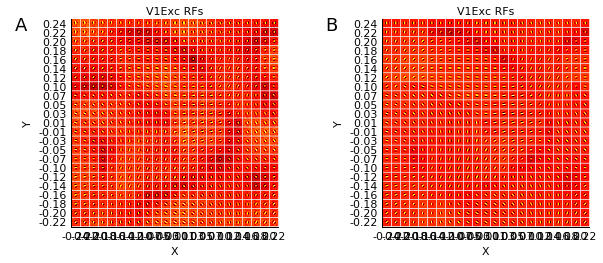

In [23]:
%%opts Image {+framewise +axiswise} GridSpace [normalize=True]
(rffit.RFGaborFit.RF_Normed + rffit.RFGaborFit.RF_Fit).cols(2).display('all')

In [22]:
%%output fig='svg' size=200 filename='RF_nxny'
%%opts RGB [fontsize={'labels':18}]
%%opts Scatter [show_grid=False] (edgecolor='k' s=50 linewidth=0.3 color='none') 
%%opts Overlay [bgcolor='w' legend_cols=1 show_frame=False] 
%%opts Path (color='k' linewidth=0.2) Image {+axiswise +framewise}

# Pick out RF at the top middle and bottom
rf_df = fit_table.data
max_ny_row = rf_df[rf_df.ny == rf_df.ny.max()]
max_ny = rffit.RFGaborFit.RF_Fit[tuple(max_ny_row.iloc[0, 0:5])]
low_ny_row = rf_df[(rf_df.ny < 0.2) & (rf_df.nx < 0.35)].sort_values('residual')
low_ny = rffit.RFGaborFit.RF_Fit[tuple(low_ny_row.iloc[0, 0:5])]
mid_ny_row = rf_df[(rf_df.nx > 0.5) & (rf_df.nx < 0.55) & (rf_df.ny > 0.3) & (rf_df.ny < 0.35)].sort_values('residual')
mid_ny = rffit.RFGaborFit.RF_Fit[tuple(mid_ny_row.iloc[0, 0:5])]

# Overlay experimental data with model data
hv.RGB.load_image('./Ringach_RFs.png', bounds=(0, 0, 1.5, 1.5), kdims=['$n_x$', '$n_y$']) *\
fit_table.to.scatter(['nx'], ['ny'], [], extents=(0, 0, 1.5, 1.5), label='SCAL')(style=dict(marker='s')) *\
hv.Scatter([(0,0)], label='Ringach et al. 2002 (macaque)')(style=dict(marker='o')) *\
hv.Scatter([(0,0)], label='Jones & Palmer 1987 (cat)')(style=dict(marker='x', color='k')) *\
low_ny.clone(bounds=(0.65, 0.2, 0.75, 0.3)) *\
hv.Path([[(low_ny_row.iloc[0]['nx'], low_ny_row.iloc[0]['ny']), (0.65, 0.2)]]) *\
mid_ny.clone(bounds=(0.7, 0.45, 0.8, 0.55)) *\
hv.Path([[(mid_ny_row.iloc[0]['nx'], mid_ny_row.iloc[0]['ny']), (0.7, 0.45)]]) *\
max_ny.clone(bounds=(0.8, 0.7, 0.9, 0.8)) *\
hv.Path([[(max_ny_row['nx'], max_ny_row['ny']), (0.8, 0.7)]])

:Overlay
   .RGB.I                                                                           :RGB   [$n_x$,$n_y$]   (R,G,B,A)
   .Scatter.SCAL                                                                    :Scatter   [nx]   (ny)
   .Scatter.Ringach_et_al_full_stop_2002_left_parenthesis_macaque_right_parenthesis :Scatter   [x]   (y)
   .Scatter.Jones_ampersand_Palmer_1987_left_parenthesis_cat_right_parenthesis      :Scatter   [x]   (y)
   .Receptive_Field.V1Exc.I                                                         :Image   [x,y]   (Weight)
   .Path.I                                                                          :Path   [x,y]
   .Receptive_Field.V1Exc.II                                                        :Image   [x,y]   (Weight)
   .Path.II                                                                         :Path   [x,y]
   .Receptive_Field.V1Exc.III                                                       :Image   [x,y]   (Weight)
   .Path.III                                                                        :Path   [x,y]